In [2]:
!pip install jieba

  Stored in directory: C:\Users\MrBonBon\AppData\Local\pip\Cache\wheels\c9\c7\63\a9ec0322ccc7c365fd51e475942a82395807186e94f0522243
Successfully built jieba


In [3]:
import jieba
from sklearn import preprocessing

pre_defined_classes = ["產業", "文教", "電視", "音樂", "產經", "新聞", "房市新訊", "消費類別處理", "生活", "地方", "兩岸", "要聞", "社會", "運動", "股市", "全球", '健行筆記', '全台好美食', '日本好好玩']

def get_dataset(filepath):
    labels = []
    texts = []
    jieba.set_dictionary('./dict.txt.big')
    with open(filepath, 'r', encoding='UTF-8') as f :
        for line in f.read().splitlines() :
            items = line.split('\t')
            if(len(items) == 3):
                labels.append(items[0])
                seg_content = ' '.join(jieba.cut(items[1]+items[2], cut_all = False))
                texts.append(seg_content)
       
    return get_encoded_label(labels), texts


def get_encoded_label(labels):
    le = preprocessing.LabelEncoder()
    le.fit(pre_defined_classes);
    return le.transform(labels)

labels, texts = get_dataset("./udnnews.txt")

Exception: jieba: file does not exist: C:\Users\MrBonBon\Documents\GitHub\AICupTMU\Bonz\usefulcodeoftextclassificationforaicup\dict.txt.big

In [12]:
from sklearn.model_selection import train_test_split 
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

training_text, test_text, training_label, test_label = train_test_split(texts, labels, test_size=0.1)

token = Tokenizer(num_words = 20000)
token.fit_on_texts(training_text)
vocab = token.word_index

x_train_seq = token.texts_to_sequences(training_text)
x_test_seq = token.texts_to_sequences(test_text)
x_train = sequence.pad_sequences(x_train_seq, maxlen = 150)
x_test = sequence.pad_sequences(x_test_seq, maxlen = 150)

y_train = np_utils.to_categorical(training_label)
y_test = np_utils.to_categorical(test_label)

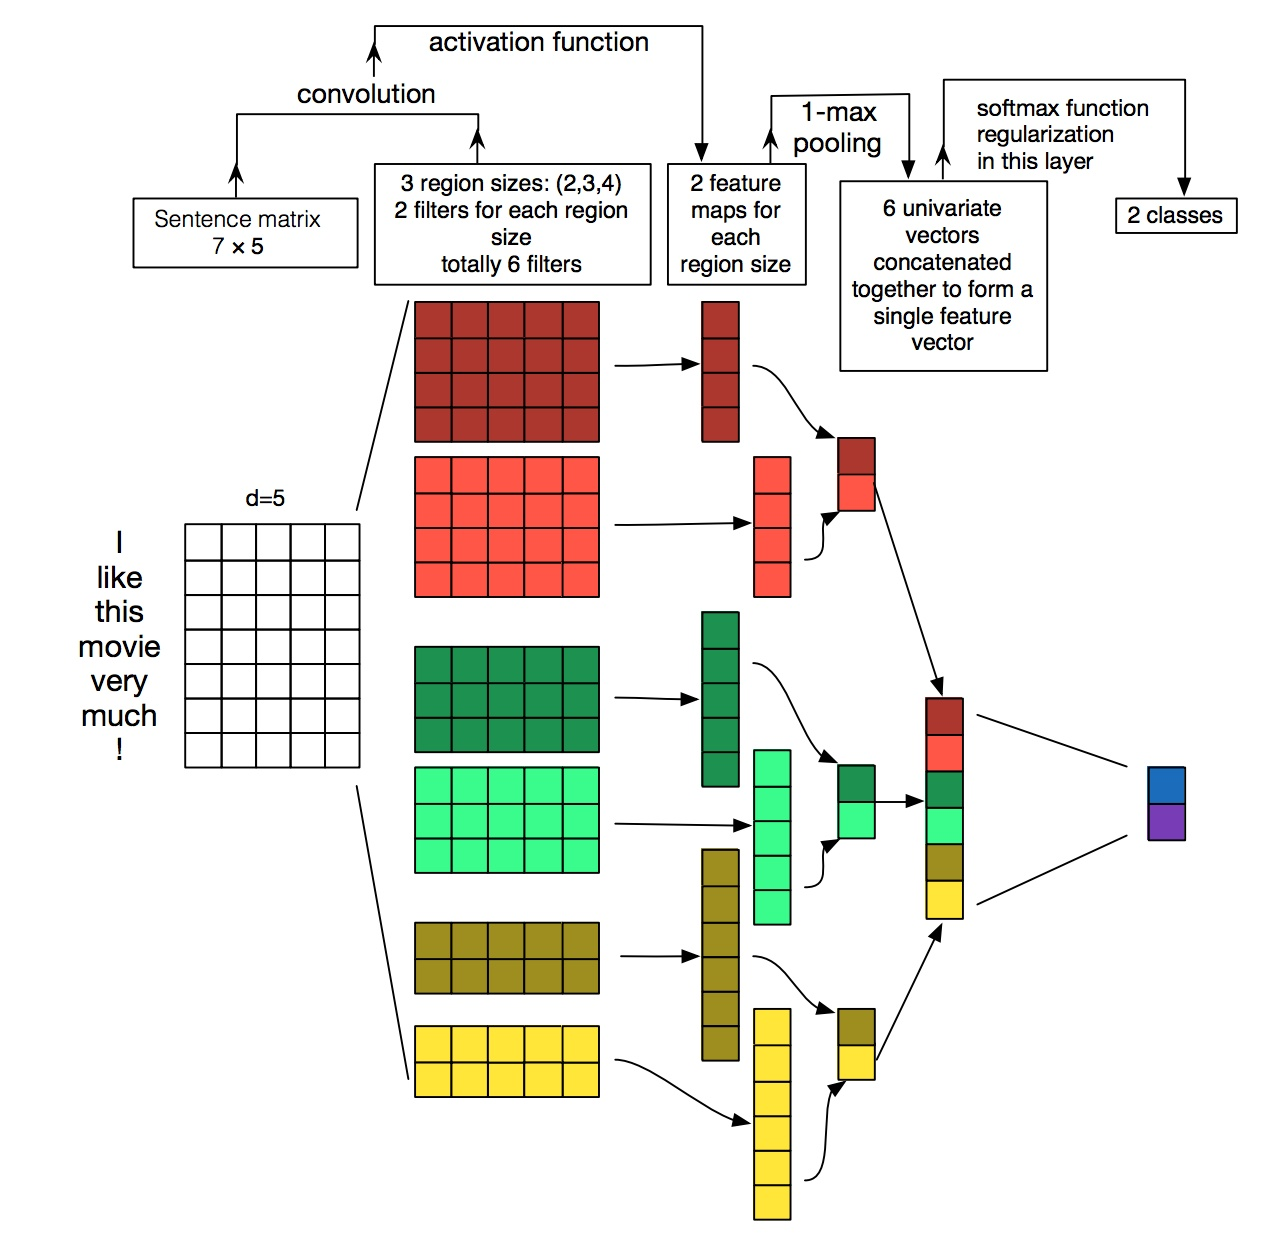

In [9]:
from IPython.core.display import Image, display
display(Image('https://pic4.zhimg.com/v2-f5b8d843f03b7436380a5e39ce30b4c3_r.jpg', width=600, unconfined=True))


In [13]:
from keras import optimizers
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Activation, merge, Input, Lambda, Reshape
from keras.layers import Convolution1D, Flatten, Dropout, MaxPool1D, GlobalAveragePooling1D
from keras import initializers
from keras import backend as K

num_labels = len(pre_defined_classes)
main_input = Input(shape=(150,), dtype='float64')
# pre-train embeddings
# embedder = Embedding(len(vocab) + 1, 300, input_length = 20, weights = [embedding_matrix], trainable = False)
# embed = embedder(main_input)

embedder = Embedding(len(vocab)+1, 300, input_length=150)
embed = embedder(main_input)

# filter size, region size
cnn1 = Convolution1D(2, 2, padding='same', strides = 1, activation='relu')(embed)
cnn1 = MaxPool1D(pool_size=4)(cnn1)
cnn2 = Convolution1D(2, 3, padding='same', strides = 1, activation='relu')(embed)
cnn2 = MaxPool1D(pool_size=4)(cnn2)
cnn3 = Convolution1D(2, 4, padding='same', strides = 1, activation='relu')(embed)
cnn3 = MaxPool1D(pool_size=4)(cnn3)

cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)
flat = Flatten()(cnn)
drop = Dropout(0.2)(flat)
main_output = Dense(num_labels, activation='softmax')(drop)
model = Model(inputs = main_input, outputs = main_output)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 300)     75606000    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 150, 2)       1202        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)    

In [14]:
optmzr = optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer=optmzr, metrics = ['accuracy'])
train_history = model.fit(x_train, y_train, batch_size = 32, epochs = 10, verbose = 1, validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 25095 samples, validate on 2789 samples
Epoch 1/10
  480/25095 [..............................] - ETA: 14:15 - loss: 2.8984 - acc: 0.0771

KeyboardInterrupt: 

In [ ]:
pre_probability = model.predict(x_test)
predicted = pre_probability.argmax(axis=-1)

from sklearn import metrics
print("Classification report for classifier:\n%s\n"
    % ( metrics.classification_report(test_label, predicted)))

from pandas_ml import ConfusionMatrix
confusion_matrix = ConfusionMatrix(test_label, predicted)
print("Confusion matrix:\n%s" % confusion_matrix)